In [1]:
#TODO:
# 1. figure out if it makes sense to rotate time series 180 days if lat < -23.44,
#    otherwise rotate some fraction between 0 and 180 days (by cos or sin of lat?)

In [4]:
import rpy2
import pyEOF

ImportError: libffi.so.7: cannot open shared object file: No such file or directory

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
#import cartopy.crs as crs
#import panel as pn
#import hvplot.xarray
from rasterio.plot import reshape_as_raster
import xarray as xr
import rioxarray as rxr
import os
import datetime
import daylight
import pytz
from shapely.geometry import Point
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from eofs.xarray import Eof

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [2]:
# plotting params
subplots_adj_left=0.05
subplots_adj_bottom=0.1
subplots_adj_right=0.95
subplots_adj_top=0.9
subplots_adj_wspace=0.2
subplots_adj_hspace=0.4

In [3]:
# NOTE on memory requirements
    #        I estimate that the global 365 x 2400 x 6900 raster will take up
    #       about 46.1 GB memory;
    #       (NOTE: I could also cast of dtype float32 and cut down to ~23 GB,
    #              for 'safety' sake)
    #       if I ran this on savio bigmem that would only be ~1/9th total RAM,
    #       so it should be doable to create a giant global 365 x 2400 x 6900
    #       numpy array and then fill it with all fitted time series and write
    #       to disk, though that's only ~1/2 RAM on savio3, so first just try
    #       there!
    #       then I could separately read in as a dask array and run EOF
    #       analysis on that, I believe.
    #       though I wonder if I could just run the EOF analysis within that
    #       same job. Not sure how much memory requirement expands as factor
    #       of size of base spatiotemporal dataset, and not easily finding that
    #       informiation on line...


# TODO:

    # could use clustering afterward, with scree plot, to determine k
    # distinct 'classes' of global phenological seasonality 'types'

In [4]:
###################
# BEHAVIORAL PARAMS
###################

# min and max x and y values, to optionally subset analysis to a region
region_name = 'global'
min_x = None
max_x = None
min_y = None
max_y = None


# analyses to run
run_eof = True
run_mds = False

# use hvplot, etc for interactive plotting?
interactive = False

# save figures and datasets?
save_res = False

# data dir on laptop
if os.getcwd().split('/')[1] == 'home':
    data_dir = '/home/deth/Desktop/CAL/research/projects/seasonality/results/maps'
# data dir on savio
else:
    data_dir = '/global/scratch/users/drewhart/seasonality/'

# set the seed
set_seed = True
if set_seed:
    seed = 1
    np.random.seed(seed)

# rotate fitted ts 180deg for S-hemisphere sites?
# NOTE: I don't think this makes any difference actually,
#       based on initial exploration (seemed to change color but not
#       point-point relationships), but just to be able to explore this more...
rotate_s_hemis = False

# normalize each ts to itself?
# NOTE: I think it makes sense to do this, since I'm only interested in timing,
#       and otherwise (especially based on Alex Turner's results in CA) I
#       expect the first EOF will largely reflect global (i.e.,
#       cross-study-area) variation in magnitude of fitted values;
#       nonetheless, setting a flag for this so that I can check that
#       expectation and check sensitivity to this decision
normalize_ts = True

# latitude weights to use?
lat_weights = 'cos'
#lat_weights = 'sqrt_cos'
#lat_weights = None

# center the data being input to EOF?
# TODO: decide about this!
center_eof = True

# number of top EOFs to use?
neofs = 4

# pctiles and counts of example time series to plot?
ts_top_pctile = 95
ts_bot_pctile = 95
n_ts_to_plot = 1000

In [5]:
###########
# FUNCTIONS
###########

def make_design_matrix():
    """
    Makes and returns the regression's design matrix, a 365 x 5 numpy array
    in which the columns contain, in order:
        - 1s (for the constant);
        - sin and cos of annual-harmonic days of the year
          (i.e. days are expressed in radians from 0 to 2pi);
        - sin and cos of the semiannual-harmonic days of the year
          (i.e. days are expressed in radians from 0 to 4pi).
    """
    # get 1 year of daily values, expressed in radians, 1 rotation/yr
    annual_radian_days = np.linspace(0, 2*np.pi, 366)[:365]
    # get 1 year of daily values, expressed in radians, 2 rotations/yr
    semiannual_radian_days = np.linspace(0, 4*np.pi, 366)[:365] % (2 * np.pi)
    # get the harmonic values of those
    sin1 = np.sin(annual_radian_days)
    cos1 = np.cos(annual_radian_days)
    sin2 = np.sin(semiannual_radian_days)
    cos2 = np.cos(semiannual_radian_days)
    # add a vector of 1s for the constant term, then recast as a 365 x 5 array,
    # to use as the covariate values in the regression
    design_mat = np.array([np.ones(sin1.shape), sin1, cos1, sin2, cos2]).T
    return design_mat

In [7]:
########################################
# READ IN COEFFS, GET ARRAY OF FITTED TS
########################################

# read global NIRv coeffs
coeffs = rxr.open_rasterio(os.path.join(data_dir, 'NIRv_global_coeffs.tif'))

# subset global raster to study area (if all Nones then not subsetted!)
# NOTE: max_y and min_y flipped because y res negative in CRS transform
coeffs = coeffs.sel(x=slice(min_x, max_x), y=slice(max_y, min_y))

# get coords arrays
X, Y = np.meshgrid(coeffs.x, coeffs.y)

In [7]:
# create empty time-series array for EOF analysis
ts_arr = np.ones((365, coeffs.shape[1], coeffs.shape[2]), dtype=np.float32) * np.nan

# make the harmonic regression's design matrix
dm = make_design_matrix()

# get the time series for each sample
# NOTE: coeffs.shape[0] == 5, one band for each regression coeff
for i in range(coeffs.shape[1]):
    for j in range(coeffs.shape[2]):
        ts = np.sum(coeffs[:, i, j].values * dm, axis=1)
        # rotate 1/2 year for southern-hemisphere sites, if stipulated
        if Y[i,j]<0:
            ts = np.array([*ts[183:]] + [*ts[:183]])
        # normalize time series [0,1], if desired
        # NOTE: if not, pretty certain that first EOF will largely capture
        #       global (i.e., across full subsetted extent) variation
        #       in fitted magnitude
        if normalize_ts and not np.any(np.isnan(ts)):
            ts = normalize([ts]).flatten()
        assert ts.shape == (365,)
        ts_arr[:, i, j] = ts
    print('\n\n\t%0.3f %% complete' % (100*((i+1)/coeffs.shape[2])))

# once complete, save this to a simple numpy array file
# (for now, anyhow; might be worth saving as a big geospatial file
#  eventually?)
if save_res:
    np.savetxt(os.path.join(data_dir, 'fitted_ts_array.txt'),
            ts_arr.reshape(ts_arr.shape[0], -1))

    # load saved data and reshape it from 2d to 3d
    ts_arr_2d = np.loadtxt(os.path.join(data_dir, 'fitted_ts_array.txt'))
    ts_arr = ts_arr_2d.reshape(ts_arr_2d.shape[0],
                               ts_arr_2d.shape[1] // coeffs.shape[2],
                               coeffs.shape[2])



	0.014 % complete


	0.029 % complete


	0.043 % complete


	0.058 % complete


	0.072 % complete


	0.087 % complete


	0.101 % complete


	0.116 % complete


	0.130 % complete


	0.145 % complete


	0.159 % complete


	0.174 % complete


	0.188 % complete


	0.203 % complete


	0.217 % complete


	0.232 % complete


	0.246 % complete


	0.261 % complete


	0.275 % complete


	0.290 % complete


	0.304 % complete


	0.319 % complete


	0.333 % complete


	0.348 % complete


	0.362 % complete


	0.377 % complete


	0.391 % complete


	0.406 % complete


	0.420 % complete


	0.435 % complete


	0.449 % complete


	0.464 % complete


	0.478 % complete


	0.493 % complete


	0.507 % complete


	0.522 % complete


	0.536 % complete


	0.551 % complete


	0.565 % complete


	0.580 % complete


	0.594 % complete


	0.609 % complete


	0.623 % complete


	0.638 % complete


	0.652 % complete


	0.667 % complete


	0.681 % complete


	0.696 % complete


	0.710 % complete


	0.725 % complete




	5.957 % complete


	5.971 % complete


	5.986 % complete


	6.000 % complete


	6.014 % complete


	6.029 % complete


	6.043 % complete


	6.058 % complete


	6.072 % complete


	6.087 % complete


	6.101 % complete


	6.116 % complete


	6.130 % complete


	6.145 % complete


	6.159 % complete


	6.174 % complete


	6.188 % complete


	6.203 % complete


	6.217 % complete


	6.232 % complete


	6.246 % complete


	6.261 % complete


	6.275 % complete


	6.290 % complete


	6.304 % complete


	6.319 % complete


	6.333 % complete


	6.348 % complete


	6.362 % complete


	6.377 % complete


	6.391 % complete


	6.406 % complete


	6.420 % complete


	6.435 % complete


	6.449 % complete


	6.464 % complete


	6.478 % complete


	6.493 % complete


	6.507 % complete


	6.522 % complete


	6.536 % complete


	6.551 % complete


	6.565 % complete


	6.580 % complete


	6.594 % complete


	6.609 % complete


	6.623 % complete


	6.638 % complete


	6.652 % complete


	6.667 % complete




	11.812 % complete


	11.826 % complete


	11.841 % complete


	11.855 % complete


	11.870 % complete


	11.884 % complete


	11.899 % complete


	11.913 % complete


	11.928 % complete


	11.942 % complete


	11.957 % complete


	11.971 % complete


	11.986 % complete


	12.000 % complete


	12.014 % complete


	12.029 % complete


	12.043 % complete


	12.058 % complete


	12.072 % complete


	12.087 % complete


	12.101 % complete


	12.116 % complete


	12.130 % complete


	12.145 % complete


	12.159 % complete


	12.174 % complete


	12.188 % complete


	12.203 % complete


	12.217 % complete


	12.232 % complete


	12.246 % complete


	12.261 % complete


	12.275 % complete


	12.290 % complete


	12.304 % complete


	12.319 % complete


	12.333 % complete


	12.348 % complete


	12.362 % complete


	12.377 % complete


	12.391 % complete


	12.406 % complete


	12.420 % complete


	12.435 % complete


	12.449 % complete


	12.464 % complete


	12.478 % complete


	12.493 % c



	17.478 % complete


	17.493 % complete


	17.507 % complete


	17.522 % complete


	17.536 % complete


	17.551 % complete


	17.565 % complete


	17.580 % complete


	17.594 % complete


	17.609 % complete


	17.623 % complete


	17.638 % complete


	17.652 % complete


	17.667 % complete


	17.681 % complete


	17.696 % complete


	17.710 % complete


	17.725 % complete


	17.739 % complete


	17.754 % complete


	17.768 % complete


	17.783 % complete


	17.797 % complete


	17.812 % complete


	17.826 % complete


	17.841 % complete


	17.855 % complete


	17.870 % complete


	17.884 % complete


	17.899 % complete


	17.913 % complete


	17.928 % complete


	17.942 % complete


	17.957 % complete


	17.971 % complete


	17.986 % complete


	18.000 % complete


	18.014 % complete


	18.029 % complete


	18.043 % complete


	18.058 % complete


	18.072 % complete


	18.087 % complete


	18.101 % complete


	18.116 % complete


	18.130 % complete


	18.145 % complete


	18.159 % c



	23.145 % complete


	23.159 % complete


	23.174 % complete


	23.188 % complete


	23.203 % complete


	23.217 % complete


	23.232 % complete


	23.246 % complete


	23.261 % complete


	23.275 % complete


	23.290 % complete


	23.304 % complete


	23.319 % complete


	23.333 % complete


	23.348 % complete


	23.362 % complete


	23.377 % complete


	23.391 % complete


	23.406 % complete


	23.420 % complete


	23.435 % complete


	23.449 % complete


	23.464 % complete


	23.478 % complete


	23.493 % complete


	23.507 % complete


	23.522 % complete


	23.536 % complete


	23.551 % complete


	23.565 % complete


	23.580 % complete


	23.594 % complete


	23.609 % complete


	23.623 % complete


	23.638 % complete


	23.652 % complete


	23.667 % complete


	23.681 % complete


	23.696 % complete


	23.710 % complete


	23.725 % complete


	23.739 % complete


	23.754 % complete


	23.768 % complete


	23.783 % complete


	23.797 % complete


	23.812 % complete


	23.826 % c



	28.812 % complete


	28.826 % complete


	28.841 % complete


	28.855 % complete


	28.870 % complete


	28.884 % complete


	28.899 % complete


	28.913 % complete


	28.928 % complete


	28.942 % complete


	28.957 % complete


	28.971 % complete


	28.986 % complete


	29.000 % complete


	29.014 % complete


	29.029 % complete


	29.043 % complete


	29.058 % complete


	29.072 % complete


	29.087 % complete


	29.101 % complete


	29.116 % complete


	29.130 % complete


	29.145 % complete


	29.159 % complete


	29.174 % complete


	29.188 % complete


	29.203 % complete


	29.217 % complete


	29.232 % complete


	29.246 % complete


	29.261 % complete


	29.275 % complete


	29.290 % complete


	29.304 % complete


	29.319 % complete


	29.333 % complete


	29.348 % complete


	29.362 % complete


	29.377 % complete


	29.391 % complete


	29.406 % complete


	29.420 % complete


	29.435 % complete


	29.449 % complete


	29.464 % complete


	29.478 % complete


	29.493 % c



	34.478 % complete


	34.493 % complete


	34.507 % complete


	34.522 % complete


	34.536 % complete


	34.551 % complete


	34.565 % complete


	34.580 % complete


	34.594 % complete


	34.609 % complete


	34.623 % complete


	34.638 % complete


	34.652 % complete


	34.667 % complete


	34.681 % complete


	34.696 % complete


	34.710 % complete


	34.725 % complete


	34.739 % complete


	34.754 % complete


	34.768 % complete


	34.783 % complete


In [8]:
# UNCOMMENT TO LOAD SAVED GLOBAL FITTED TS DATA:

# load saved data and reshape it from 2d to 3d
#ts_arr_2d = np.loadtxt(os.path.join(data_dir, 'fitted_ts_array.txt'))
ts_arr = ts_arr_2d.reshape(ts_arr_2d.shape[0],
                           ts_arr_2d.shape[1] // coeffs.shape[2],
                           coeffs.shape[2])

# get coords arrays
X, Y = np.meshgrid(coeffs.x, coeffs.y)

In [9]:
#########
# RUN EOF
#########
if run_eof:

    # calculate weights array requested
    if lat_weights == 'cos':
        weights = np.cos(np.deg2rad(Y))
        weights /= weights.mean()
    elif lat_weights == 'sqrt_cos':
        weights = np.sqrt(np.cos(np.deg2rad(Y)))
        weights /= weights.mean()
    else:
        weights = None


    # coerce ts array to rio xarray obj
    ts_da = xr.DataArray([coeffs[0,:,:]*np.nan]*365) 
    ts_da.attrs = coeffs.attrs
    ts_da.attrs['long_name'] = ['d%i' % i for i in range(1, 366)]
    ts_da = ts_da.rename({'dim_0': 'time',
                          'dim_1': 'y',
                          'dim_2': 'x',
                          })
    ts_da = ts_da.assign_coords({'time': range(1, 366),
                                 'y': coeffs.y.values,
                                 'x': coeffs.x.values,
                                 })
    ts_da = ts_da.rio.write_crs(4326)
    ts_da.rio.set_crs(4326)
    ts_da.loc[:,:,:] = ts_arr

    # use empirical orthogonal functions to collapse global ts into
    # main modes of variation
    solver = Eof(ts_da, weights=weights)

In [10]:
    # grab the first n EOFs
    # (and swap axes so that 3rd axis is of length neofs, to facilitate image
    # plotting)
    eofs = solver.eofsAsCorrelation(neofs=neofs)

    # grab the PCs
    pcs = solver.pcs(npcs=neofs, pcscaling=1)

    # grab pct variances of EOFs
    var_pcts = solver.varianceFraction(neofs)

    # reconstruct the field using just the selected top EOFs
    ts_recon = solver.reconstructedField(neofs)

    # write eofs to file, if requested
    if save_res:
        tif_filename = '%s_%i_EOFs_%s%s%s.tif' % (region_name, neofs,
                                                lat_weights + 'wts',
                                                '_shemrot' * rotate_s_hemis,
                                                '_normts' * normalize_ts,)
        eof_res_for_file = eofs.to_dataset('mode')
        eof_res_for_file = eof_res_for_file.rename_vars(
                                        {i: 'eof%i' % i for i in range(neofs)})
        eof_res_for_file.rio.to_raster(os.path.join(data_dir, tif_filename),
                           dtype=np.float32,
                           tags={'eof%i_pctvar' % i:
                                 str(var_pcts.values[i]) for i in range(neofs)},
                          )

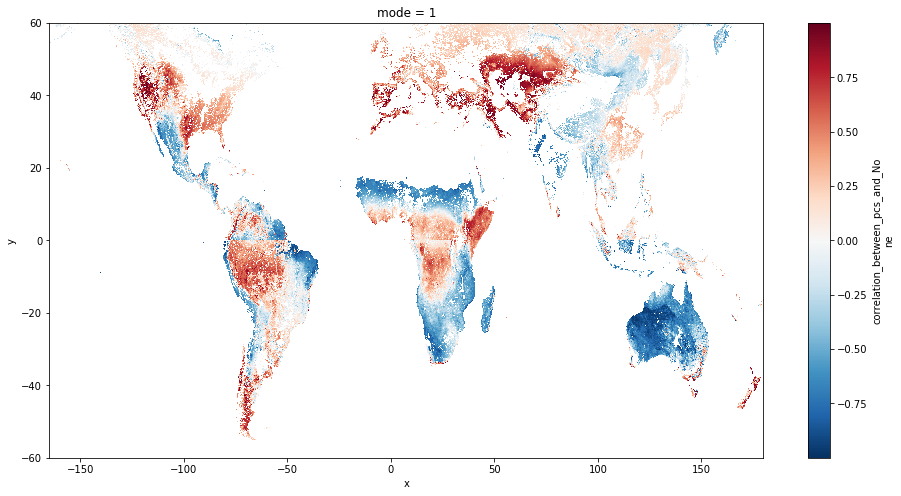

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
eofs.sel(mode=1).plot.imshow(ax=ax)

[70.78251, 17.540157, 7.633776, 4.0435643, 4.12093e-11, 4.5056456e-15, 4.00335e-15, 3.9301596e-15, 3.9029076e-15, 3.8957095e-15]


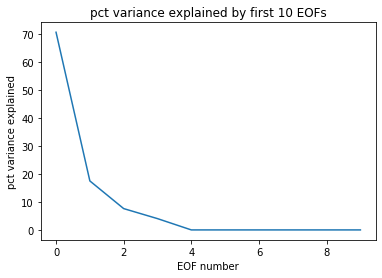

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(solver.varianceFraction(10)*100)
ax.set_title('pct variance explained by first 10 EOFs')
ax.set_xlabel('EOF number')
ax.set_ylabel('pct variance explained')
print([*solver.varianceFraction(10).values*100])

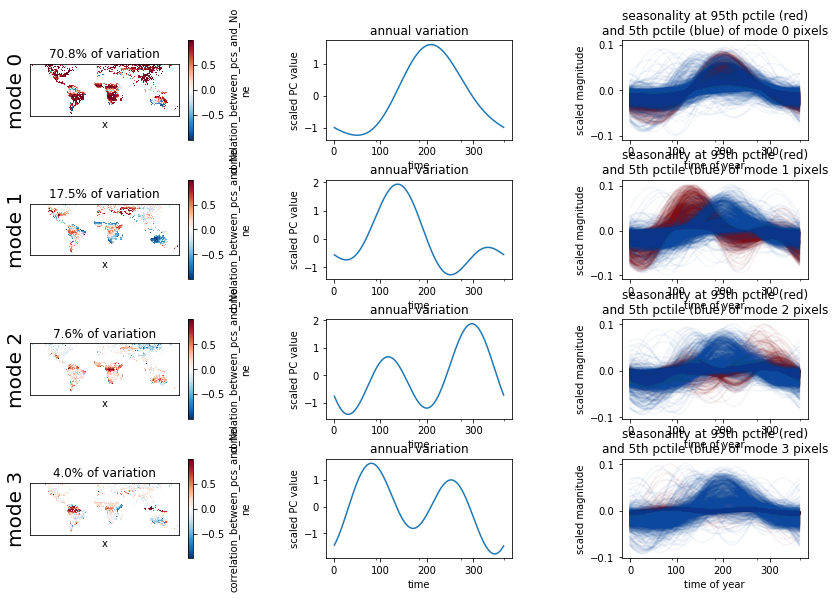

In [13]:
if run_eof:
    #########################################################################
    # MAP AND PLOT CHARACTERISTIC SEASONAL PATTERNS AT ENDS OF EACH EOF RANGE
    #########################################################################

    fig = plt.figure(figsize=(12,9))
    gs = fig.add_gridspec(nrows=neofs, ncols=5, width_ratios=[1,0.3,1,0.3,1])
    for neof in range(neofs):
        ax_map = fig.add_subplot(gs[neof, 0])
        eofs.sel(mode=neof).plot.imshow(ax=ax_map)
        ax_map.set_aspect('equal')
        ax_map.set_xticks(())
        ax_map.set_yticks(())
        ax_map.set_xticklabels(())
        ax_map.set_yticklabels(())
        ax_map.set_ylabel('mode %i' % neof, fontdict={'fontsize': 20})
        ax_map.set_title('%0.1f%% of variation' % (var_pcts[neof]*100))
        ax_pc_plot = fig.add_subplot(gs[neof,2])
        ax_pc_plot.set_xlabel('time of year')
        ax_pc_plot.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul',
                                                       'Oct', 'Jan'])
        pcs.sel(mode=neof).plot(ax=ax_pc_plot)
        ax_pc_plot.set_title('annual variation')
        ax_pc_plot.set_ylabel('scaled PC value')
        ax_examp_ts = fig.add_subplot(gs[neof,4])
        top_ts = ts_recon.values[:,
            eofs.sel(mode=neof)>=np.nanpercentile(eofs.sel(mode=neof), ts_top_pctile)].T
        idxs_to_plot = np.random.choice(range(top_ts.shape[0]), size=n_ts_to_plot, replace=False)
        ts_to_plot = top_ts[idxs_to_plot,:]
        for ts in ts_to_plot:
            ax_examp_ts.plot(range(365), ts, alpha=0.05, color='#850c10')
        bot_ts = ts_recon.values[:,
            eofs.sel(mode=neof)<=np.nanpercentile(eofs.sel(mode=neof), ts_bot_pctile)].T
        idxs_to_plot = np.random.choice(range(bot_ts.shape[0]), size=n_ts_to_plot, replace=False)
        ts_to_plot = bot_ts[idxs_to_plot,:]
        for ts in ts_to_plot:
            ax_examp_ts.plot(range(365), ts, alpha=0.05, color='#0b489e')
        ax_examp_ts.set_xlabel('time of year')
        ax_examp_ts.set_ylabel('scaled magnitude')
        ax_examp_ts.set_title(('seasonality at 95th pctile (red)\n'
                            'and 5th pctile (blue) of mode %i pixels') % neof)
        ax_examp_ts.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul',
                                                        'Oct', 'Jan'])
    fig.subplots_adjust(left=subplots_adj_left,
                         bottom=subplots_adj_bottom,
                         right=subplots_adj_right,
                         top=subplots_adj_top,
                         wspace=subplots_adj_wspace,
                         hspace=subplots_adj_hspace)
    fig.show()
    if save_res:
        fig_filename = '%s_EOF_results_scat_%s%s%s.png' % (region_name,
                                                lat_weights + 'wts',
                                                '_shemrot' * rotate_s_hemis,
                                                '_normts' * normalize_ts,)
        fig.savefig(os.path.join(data_dir, fig_filename), dpi=500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


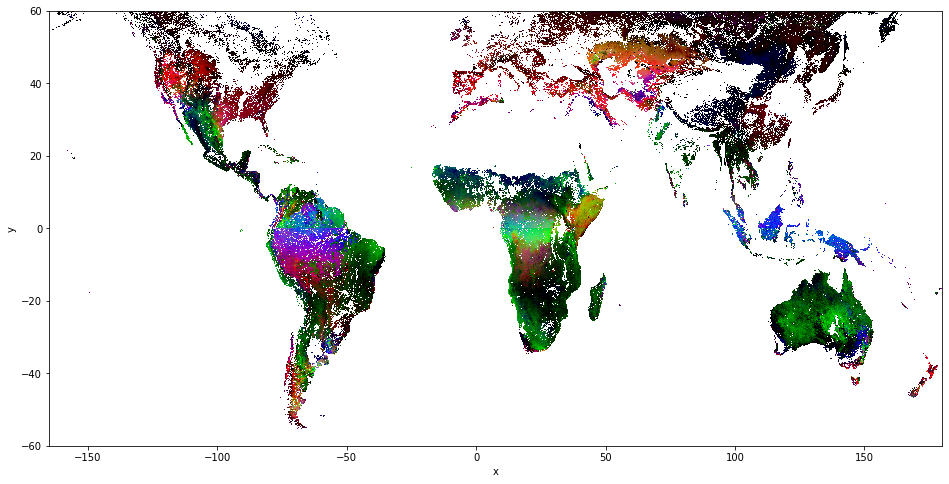

In [14]:
if run_eof:
    ##################################### 
    # USE HVPLOT FOR INTERACTIVE PLOTTING
    ##################################### 

    eofs4 = solver.eofsAsCorrelation(neofs=4)
    if interactive:

        # plot top 3 EOFs as RGB image
        rgb_plot = eofs4[1:].hvplot.rgb(x='x', y='y', bands='mode',
                                   geo=True,
                                   #coastlines=True,
                                   alpha=0.4,
                                   #responsive=True,
                                   width=800,
                                   height=600,
                                   title='top 3 EOFs in R, G, B channels',
                                   tiles='EsriReference',
                                   data_aspect=1)
        pn.serve(rgb_plot)
    else:
        fig2 = plt.figure(figsize=(16,8))
        ax_rgb = fig2.add_subplot(111)
        eofs4[1:].plot.imshow(ax=ax_rgb)
        fig2.show()

In [1]:
#######################
# EMBED IN 3D USING MDS
#######################
if run_mds:

    # take subsample of full grid

    # use metric multidimensional scaling to embed sample points' 365-length
    # time series in 3-dimensional space (which I'll then map to RGB for mapping),
    # using pairwise Euclidean distance between the 365-d points as dissim metric
    mds_ts_arr = ts_arr.reshape(ts_arr.shape[0],-1).T
    mds_ts_arr = mds_ts_arr[~np.isnan(mds_ts_arr).any(axis=1)]
    mds = MDS(n_components=3, metric=True)
    mds_axes = mds.fit_transform(mds_ts_arr)
    # normalize the mds_axes columns, to then map onto RGB colors
    mds_axes_norm = ((mds_axes - np.min(mds_axes, axis=0)) /
                   (np.max(mds_axes, axis=0) - np.min(mds_axes, axis=0)))

In [1]:
if run_mds:
    #####################################################
    # PLOT IN 3D, AND MAP, AND PLOT CHARACTERISTIC CURVES
    #####################################################

    #grid MDS values
    mds_res = coeffs[:3,:,:]*np.nan
    mds_val_ct = 0
    for x, y in zip(X.flatten(), Y.flatten()):
        if not np.isnan(coeffs[0,:,:].sel(x=x, y=y)):
            mds_res.loc[{'x':x, 'y':y}] = mds_axes_norm[mds_val_ct,:]
            mds_val_ct += 1

    # write gridded results to raster
    try:
        scale_factor = mds_res.attrs['scale_factor']
    except Exception:
        scale_factor = 1.
    try:
        add_offset = mds_res.attrs['add_offset']
    except Exception:
        add_offset = 0.
    try:
        _FillValue = mds_res.attrs['_FillValue']
    except Exception:
        _FillValue = -9999
    mds_res.attrs.clear()
    mds_res.attrs['scale_factor'] = scale_factor
    mds_res.attrs['add_offset'] = add_offset
    mds_res.attrs['_FillValue'] = _FillValue
    mds_res.attrs['long_name'] = ['R', 'G', 'B']

    outfilename = os.path.join(data_dir,  '%s_MDS_res.tif' % region_name)
    mds_res.rio.to_raster(outfilename)


    # map results
    fig4 = plt.figure(figsize=(16,12))
    gs = fig4.add_gridspec(nrows=6, ncols=4,
                           width_ratios=[1,1,0.5,0.5])
    ax_scat = fig4.add_subplot(gs[:3, 2:4], projection='3d')
    ax_scat.scatter(mds_axes[:,0], mds_axes[:,1], mds_axes[:,2],
                    c=mds_axes_norm, alpha=0.05)
    ax_scat.set_xlabel('MDS AX 1')
    ax_scat.xaxis.label.set_color('red')
    ax_scat.set_ylabel('MDS AX 2')
    ax_scat.yaxis.label.set_color('green')
    ax_scat.set_zlabel('MDS AX 3')
    ax_scat.zaxis.label.set_color('blue')
    ax_scat.set_xticks(())
    ax_scat.set_xticklabels(())
    ax_scat.set_yticks(())
    ax_scat.set_yticklabels(())
    ax_scat.set_zticks(())
    ax_scat.set_zticklabels(())

    ax_map = fig4.add_subplot(gs[:,0:2])
    countries = gpd.read_file(os.path.join(data_dir, 'NewWorldFile_2020.shp'))
    countries = countries.to_crs(4326)
    countries.plot(facecolor='none',
                   edgecolor='black',
                   linewidth=0.5,
                   ax=ax_map)
    mds_res.plot.imshow(ax=ax_map)
    ax_map.set_xlim((np.min(coeffs.x), np.max(coeffs.x)))
    ax_map.set_ylim((np.min(coeffs.y), np.max(coeffs.y)))
    ax_map.set_xlabel('')
    ax_map.set_ylabel('')
    ax_map.set_xticks(())
    ax_map.set_xticklabels(())
    ax_map.set_yticks(())
    ax_map.set_yticklabels(())
    ax_map.set_title('')
    ax_ax1_lo = fig4.add_subplot(gs[3,2])
    ax_ax1_hi = fig4.add_subplot(gs[3,3])
    ax_ax2_lo = fig4.add_subplot(gs[4,2])
    ax_ax2_hi = fig4.add_subplot(gs[4,3])
    ax_ax3_lo = fig4.add_subplot(gs[5,2])
    ax_ax3_hi = fig4.add_subplot(gs[5,3])
    for i in zip(*np.where(mds_axes[:,0]<=np.percentile(mds_axes[:,0], 5))):
        ax_ax1_lo.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    for i in zip(*np.where(mds_axes[:,0]>=np.percentile(mds_axes[:,0], 95))):
        ax_ax1_hi.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    for i in zip(*np.where(mds_axes[:,1]<=np.percentile(mds_axes[:,1], 5))):
        ax_ax2_lo.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    for i in zip(*np.where(mds_axes[:,1]>=np.percentile(mds_axes[:,1], 95))):
        ax_ax2_hi.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    for i in zip(*np.where(mds_axes[:,2]<=np.percentile(mds_axes[:,2], 5))):
        ax_ax3_lo.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    for i in zip(*np.where(mds_axes[:,2]>=np.percentile(mds_axes[:,2], 95))):
        ax_ax3_hi.plot(range(365), mds_ts_arr[i], alpha=0.1, color=mds_axes_norm[i])
    ax_ax1_lo.set_ylabel('MDS AX1')
    ax_ax1_lo.yaxis.label.set_color('red')
    ax_ax2_lo.set_ylabel('MDS AX2')
    ax_ax2_lo.yaxis.label.set_color('green')
    ax_ax3_lo.set_ylabel('MDS AX3')
    ax_ax3_lo.yaxis.label.set_color('blue')
    ax_ax3_lo.set_xlabel('time of year')
    ax_ax3_hi.set_xlabel('time of year')
    ax_ax3_lo.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul', 'Oct', 'Jan'])
    ax_ax3_hi.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul', 'Oct', 'Jan'])
    for ax in [ax_ax1_lo, ax_ax1_hi, ax_ax2_lo, ax_ax2_hi, ax_ax3_lo, ax_ax3_hi]:
        ax.set_yticks(())
        ax.set_yticklabels(())
    for ax in [ax_ax1_lo, ax_ax1_hi, ax_ax2_lo, ax_ax2_hi]:
        ax.set_xticks(())
        ax.set_xticklabels(())
    fig4.subplots_adjust(left=subplots_adj_left,
                         bottom=subplots_adj_bottom,
                         right=subplots_adj_right,
                         top=subplots_adj_top,
                         wspace=subplots_adj_wspace,
                         hspace=subplots_adj_hspace)
    if save_res:
        fig4_filename = '%s_MDS_results_scat.png' % region_name
        fig4.savefig(os.path.join(data_dir, fig4_filename), dpi=100)
    fig4.show()